# Binance Profit Calculator 
`Written by @cryptoDey94 (telegram)` <br/>
Donations Appreciated :)<br/>
BTC Address: 1MLadoaCujyjXZUfbKR4greXiR84SaH4T8 <br/>

## Designed for use with [Gunbot](https://github.com/GuntharDeNiro/BTCT/wiki), but will work for any binance trading history. 


# Usage Instructions


## Download trading history from Binance

Log on to Binance and navigate to `Orders` -> `Trade History`. On the top right should be an option `Export complete trade history`. Click on that, chose a time period, and download the excel file. Make sure this .ipynb fle is in the same folder as `TradeHistory.xlsx`. (If filename is different than that, change the filename in the below cell).

In [1]:
filename = 'TradeHistory.xlsx'

## Run this file

#### Traditional Way
To run this file, I reccomend using Anaconda Navigator. To download, click the link below. Then open Anaconda Navigator, and click `Launch` under `Jupyter notebook`. Your browser will open with a screen to select which .ipynb file to open. Download and open this one, but before running, finish reading instructions. 
https://www.anaconda.com/download/

#### Easy way (Recommended)
Create an empty github repository for free, and just upload your `TradingHistory.xlsx` file and this .ipynb file to your github repo. Since github will only run this once the first time you upload it, to update the results with new trade history file, simply delete both files from github, change this .ipynb file name to a new name and re upload it to github along with the new trading history. Then github will detect it as a new file and re calculate. :)

## Notes on the program

The program calculates profits based on round-trip trades in the given time period. That is, for each coin pair, any sells that come before any buys and any buys that come after any sells will not be calculated. Thus, only full trades (trades that contain a buy and a sell) will be calcuated for profit. This is the most accurate way to determine how much profit you accumulated in the given time period of the exported excel file.

The program calculates fees based on BNB. If you do not use BNB for fees, A. You should since its half the cost and B. you need to set the variable `use_fees` below to `False`. Note, this will calculate total profit without fees included.

In [2]:
use_fees = True

In [3]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import datetime as datetime
import requests
import warnings
warnings.filterwarnings("ignore")

# initialize variables we will need
i = 0
totalProfit = 0.0
rawGroupDfs = {}
brokenDf = pd.DataFrame(columns=['Name', 'Total Bought', 'Total Sold', 'Profit', 'Fee'])
resultDf = pd.DataFrame()

In [4]:
df = pd.read_excel(filename)

df['Date'] = df['Date(UTC)']
end = pd.to_datetime(df['Date'].iloc[0]).strftime('%I:%M %p on %B %d, %Y')
start = pd.to_datetime(df['Date'].iloc[-1]).strftime('%I:%M %p on %B %d, %Y')
print('\n')
print('Will calculate profit from ' + start + ' to ' + end)
print('\n')
print('Successfully Imported Excel File. Printing first 10 rows...')
df.head(10)



Will calculate profit from 04:01 AM on April 27, 2018 to 06:23 AM on May 04, 2018


Successfully Imported Excel File. Printing first 10 rows...


,Date(UTC),Market,Type,Price,Amount,Total,Fee,Fee Coin,Date
0,2018-05-04 06:23:50,NEBLBTC,SELL,0.001645,18.53,0.030480,0.009884,BNB,2018-05-04 06:23:50
1,2018-05-04 04:20:21,IOSTBTC,BUY,0.000007,677.00,0.004610,0.001535,BNB,2018-05-04 04:20:21
2,2018-05-04 04:20:21,IOSTBTC,BUY,0.000007,370.00,0.002520,0.000839,BNB,2018-05-04 04:20:21
3,2018-05-04 04:20:21,IOSTBTC,BUY,0.000007,7253.00,0.049393,0.016446,BNB,2018-05-04 04:20:21
4,2018-05-04 04:20:21,IOSTBTC,BUY,0.000007,370.00,0.002516,0.000839,BNB,2018-05-04 04:20:21
5,2018-05-04 04:16:09,QTUMBTC,BUY,0.002384,4.29,0.010227,0.003339,BNB,2018-05-04 04:16:09
6,2018-05-04 04:16:09,QTUMBTC,BUY,0.002386,31.82,0.075923,0.024764,BNB,2018-05-04 04:16:09
7,2018-05-04 04:13:00,WTCBTC,SELL,0.001808,16.98,0.030708,0.009955,BNB,2018-05-04 04:13:00
8,2018-05-04 03:03:54,SNTBTC,SELL,0.000018,110.00,0.001956,0.000633,BNB,2018-05-04 03:03:54
9,2018-05-04 03:03:54,SNTBTC,SELL,0.000018,1603.00,0.028469,0.009192,BNB,2018-05-04 03:03:54


The below code sanitizes the data and calculates profits based on the complete trades rules we have set above in `O(n)` time. 

In [5]:
xls = df.groupby(df['Market'], as_index=False)
clean_groups = []
#loop start - long cell bc all work being calculated in one go AKA O(n)
for name, group in xls:
    
    group = group.sort_values(by=['Date'], ascending=True)
    rawGroupDfs[name] = copy.deepcopy(group)
    
    # Create group dataframes for profit calculations
    group_df = pd.DataFrame(columns=['Total Bought', 'Total Sold', 'Profit', 'Fee'])

    # Remove sells from bottom
    group = group.reset_index()
    for index, row in group.iterrows():
        if row['Type'] == 'SELL':
            group.drop(index, inplace=True)
        else:
            break

    # Remove buys from top
    while group['Type'].count() > 0 and group.iloc[-1]['Type'] == 'BUY':
        group = group[:-1]


    # check for groups that only sold or bought, dont count them
    if len(group['Type'].unique()) == 1:
        continue
        
    
    # Calculate profits
    totalCostForCurrentGroup = 0.0
    totalRevenueForCurrentGroup = 0.0
    totalProfitForCurrentGroup = 0.0
    totalFeeForCurrentGroup = 0.0
    totalAmountForBuys = 0.0
    totalAmountForSells = 0.0

    for index, row in group.iterrows():
        totalFeeForCurrentGroup = totalFeeForCurrentGroup + float(row['Fee'])
        if row['Type'] == 'BUY':
            totalAmountForBuys = totalAmountForBuys + float(row['Amount'])
            totalCostForCurrentGroup = totalCostForCurrentGroup + float(row['Total'])
            
        if row['Type'] == 'SELL':
            totalAmountForSells = totalAmountForSells + float(row['Amount'])
            totalRevenueForCurrentGroup = totalRevenueForCurrentGroup + float(row['Total'])
        
        


    # sometimes there is a slight difference in the amount bought / sold 
    # (maybe limit orders didnt get fully filled in time or owned coins from prev trades)
    # We will recalculate profits of those groups to be conservative to the lower amount
    group_df = pd.DataFrame()

    if totalAmountForSells > totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)
        totalRevenueForCurrentGroup = totalRevenueForCurrentGroup * (totalAmountForBuys / totalAmountForSells)
        totalFeeForCurrentGroup = totalFeeForCurrentGroup * (totalAmountForBuys / totalAmountForSells)
        print('Fixing relative revenue for group ' + name)
        print('\n')
        
        
    if totalAmountForSells < totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)        
        totalCostForCurrentGroup = totalCostForCurrentGroup * (totalAmountForSells / totalAmountForBuys)
        totalFeeForCurrentGroup = totalFeeForCurrentGroup * (totalAmountForSells / totalAmountForBuys)
        print('Fixing relative cost for group ' + name)
        print('\n')


    totalProfitForCurrentGroup = totalRevenueForCurrentGroup - totalCostForCurrentGroup
    
    group_df = group_df.set_value(i, 'Total Bought', totalAmountForBuys)
    group_df = group_df.set_value(i, 'Total Sold', totalAmountForSells)
    group_df = group_df.set_value(i, 'Profit', totalProfitForCurrentGroup)
    group_df = group_df.set_value(i, 'Fee', totalFeeForCurrentGroup)
    group_df = group_df.set_value(i, 'Name', name)

    if totalProfitForCurrentGroup > 0 :
        resultDf = resultDf.append(group_df)
    else: 
        brokenDf = brokenDf.append(group_df)
        if totalProfitForCurrentGroup == 0.0:
            print('Pair ' + name + ' had no round trip trades in this time period')
            print('\n')
        else:
            print('The pair ' + name + ' was manually sold for a loss or the pair is in RT mode. Please re-run the script once the pair sells for a profit. Currently, we are not counting any profitable trades from ' + name + '.')
            print(str(totalProfitForCurrentGroup))
            print('\n')

    i = i + 1
    
#loop over

Fixing relative cost for group AEBTC


The pair AEBTC was manually sold for a loss or the pair is in RT mode. Please re-run the script once the pair sells for a profit. Currently, we are not counting any profitable trades from AEBTC.
-0.007006110999999704


Fixing relative cost for group ARKBTC


Fixing relative cost for group BCDBTC


Fixing relative revenue for group BTGBTC


Pair DGDBTC had no round trip trades in this time period


The pair ELFBTC was manually sold for a loss or the pair is in RT mode. Please re-run the script once the pair sells for a profit. Currently, we are not counting any profitable trades from ELFBTC.
-0.0004578500000000929


The pair EOSBTC was manually sold for a loss or the pair is in RT mode. Please re-run the script once the pair sells for a profit. Currently, we are not counting any profitable trades from EOSBTC.
-0.00697455800000002


The pair GRSBTC was manually sold for a loss or the pair is in RT mode. Please re-run the script once the pair sells f

In [6]:
print('Successful calculation of below groups: If -, then that means we are counting all')
resultDf.fillna('-')

Successful calculation of below groups: If -, then that means we are counting all


,Fee,Name,Only counting,Profit,Total Bought,Total Sold
0,0.133209,ADABTC,-,0.001313,5479.000,5479.000
2,0.113508,ARKBTC,452.03,0.001500,452.030,452.030
3,0.097621,BCCBTC,-,0.002054,1.021,1.021
4,0.095217,BCDBTC,44.214,0.001584,44.214,44.214
5,0.096785,BTGBTC,18.5,0.002386,18.500,18.500
6,0.173128,BTSBTC,-,0.008134,7770.000,7770.000
7,0.245107,CNDBTC,-,0.002085,33461.000,33461.000
8,0.044696,DASHBTC,-,0.002019,1.330,1.330
12,0.095441,ETCBTC,-,0.002491,65.050,65.050
13,0.148665,GASBTC,-,0.002773,76.560,76.560


In [7]:
profitDf = pd.DataFrame(columns=['Total Profit BTC', 'Total Fees BNB'])
profitDf['Total Profit BTC'] = [resultDf['Profit'].sum()]
profitDf['Total Fees BNB'] = [resultDf['Fee'].sum()]
profitDf.index = ['Total']

The below pairs were not added to final result. If 0, then no round trip trades for these groups exist in the given time period. If running many pairs and time range is small, this is expected.
If negative, user manually sold for a loss and it is not counted, or the pair is currently in RT mode and not counted. Note: this means that the total profit displayed is the lower bound.
For 100% accurate results, wait for all RT trades to finish, then re download trade history and re run this script.

In [8]:
brokenDf = brokenDf.drop('Only counting', 1)
brokenDf

,Fee,Name,Profit,Total Bought,Total Sold
1,0.413676,AEBTC,-0.007006,1419.190,1419.190
9,0.000000,DGDBTC,0.000000,0.000,0.000
10,0.273069,ELFBTC,-0.000458,2270.000,2270.000
11,0.430315,EOSBTC,-0.006975,335.140,335.140
14,0.266616,GRSBTC,-0.008464,2759.000,2759.000
17,0.277661,ICXBTC,-0.006844,916.020,916.020
18,0.170598,IOSTBTC,-0.003406,48383.000,59079.000
24,0.128635,MCOBTC,-0.001949,160.430,160.430
32,0.169081,QTUMBTC,-0.002311,113.440,113.440
34,0.713925,STEEMBTC,-0.006865,2553.010,2553.010


In [9]:
#USD Profits
usProfitDf = pd.DataFrame(index=[8000, 10000, 12000, 15000, 20000, 25000, 50000, 100000], 
                          columns=['USD Profit if cost of BTC is ...'])
    
usProfitDf.index.name = 'Price BTC'

In [10]:
# Get profit in USD from real time BTC price from coinmarketcap
response = requests.get('https://api.coinmarketcap.com/v1/ticker/bitcoin/') 
response2 = requests.get('https://api.coinmarketcap.com/v1/ticker/binance-coin/') 

realTimeProfitDf = pd.DataFrame(index=['Total'])
if use_fees is True:
    usProfitDf['USD Profit if cost of BTC is ...'] = usProfitDf.index * float(resultDf['Profit'].sum()) - float(response2.json()[0]['price_usd']) * float(resultDf['Fee'].sum())
    realTimeProfitDf['USD Profit if cost of BTC is ...'] = float(response.json()[0]['price_usd']) * float(resultDf['Profit'].sum()) - float(response2.json()[0]['price_usd']) * float(resultDf['Fee'].sum())
else:
    usProfitDf['USD Profit if cost of BTC is ...'] = usProfitDf.index * float(resultDf['Profit'].sum())
    realTimeProfitDf['USD Profit if cost of BTC is ...'] = float(response.json()[0]['price_usd']) * resultDf['Profit'].sum()

In [11]:
profitDf

,Total Profit BTC,Total Fees BNB
Total,0.102402,5.598173


In [12]:
pd.options.display.float_format = '${:,.2f}'.format
print(usProfitDf.to_string(index=True))

           USD Profit if cost of BTC is ...
Price BTC                                  
8000                                $738.17
10000                               $942.97
12000                             $1,147.78
15000                             $1,454.99
20000                             $1,967.00
25000                             $2,479.01
50000                             $5,039.06
100000                           $10,159.18


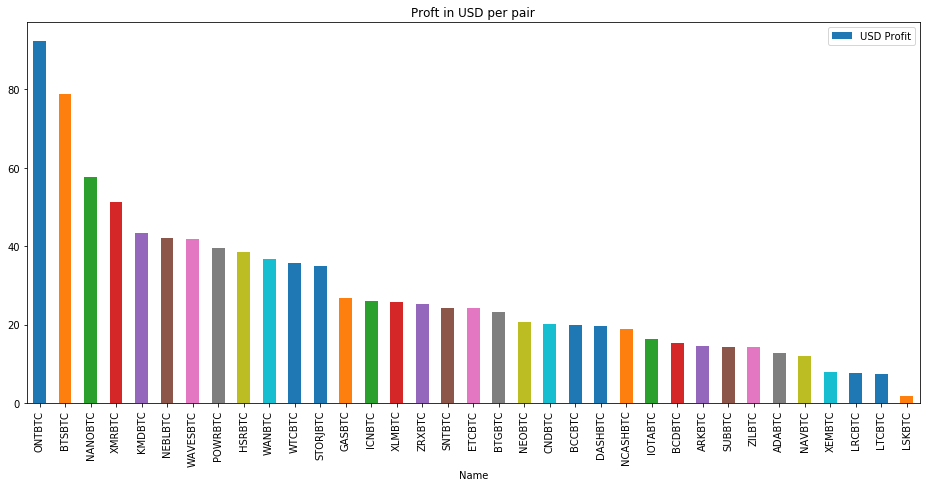

In [13]:
resultDf['USD Profit'] = (float(response.json()[0]['price_usd']) * resultDf['Profit'])
resultDf = resultDf.sort_values(by='USD Profit', ascending=False)

ax = resultDf.plot(x='Name', y='USD Profit', kind='bar', figsize=(16,7), title='Proft in USD per pair')
plt.show()

In [14]:
finalDf = pd.DataFrame(resultDf[['Name','USD Profit']])
print(finalDf.to_string(index=False))

Name  USD Profit
  ONTBTC      $92.50
  BTSBTC      $78.80
 NANOBTC      $57.75
  XMRBTC      $51.22
  KMDBTC      $43.35
 NEBLBTC      $41.99
WAVESBTC      $41.86
 POWRBTC      $39.52
  HSRBTC      $38.49
  WANBTC      $36.73
  WTCBTC      $35.83
STORJBTC      $34.90
  GASBTC      $26.86
  ICNBTC      $25.97
  XLMBTC      $25.89
  ZRXBTC      $25.22
  SNTBTC      $24.34
  ETCBTC      $24.13
  BTGBTC      $23.12
  NEOBTC      $20.68
  CNDBTC      $20.20
  BCCBTC      $19.90
 DASHBTC      $19.56
NCASHBTC      $18.84
 IOTABTC      $16.44
  BCDBTC      $15.35
  ARKBTC      $14.53
  SUBBTC      $14.30
  ZILBTC      $14.29
  ADABTC      $12.72
  NAVBTC      $12.06
  XEMBTC       $7.97
  LRCBTC       $7.59
  LTCBTC       $7.32
  LSKBTC       $1.85


In [15]:
print('\n')
print ('Current Bitcoin Price as of ' + datetime.datetime.now().strftime('%I:%M %p on %B %d, %Y') + ' is: ' + "${:,.2f}".format(float(response.json()[0]['price_usd'])))
print('\n')



Current Bitcoin Price as of 03:29 AM on May 04, 2018 is: $9,687.96




In [16]:
feeCost = float(response2.json()[0]['price_usd']) * float(resultDf['Fee'].sum())
label = str('Profit from ' + str(start) + ' to ' + str(end) + ' in USD')
realTimeProfitDf.columns=[label]

print('\n')
print(str('Fee\'s from BNB ' + str(start) + ' to ' + str(end) + ' currently costs ' + "${:,.2f}".format(feeCost) + ' in USD.'))
print('\n')

realTimeProfitDf



Fee's from BNB 04:01 AM on April 27, 2018 to 06:23 AM on May 04, 2018 currently costs $81.05 in USD.




,"Profit from 04:01 AM on April 27, 2018 to 06:23 AM on May 04, 2018 in USD"
Total,$911.02


In [17]:
end = pd.to_datetime(df['Date'].iloc[0])
start = pd.to_datetime(df['Date'].iloc[-1])

diff = end - start

days, seconds = diff.days, diff.seconds
if days == 0:
    days = 1
hours = days * 24.0 + seconds // 3600.0
minutes = hours * 60.0

priceBTC = float(response.json()[0]['price_usd'])
avgProfMin = resultDf['Profit'].sum() * priceBTC / minutes
avgProfHour = resultDf['Profit'].sum() * priceBTC / hours
avgProfDay = resultDf['Profit'].sum() * (priceBTC / days)

btcProfit = resultDf['Profit'].sum()
print('Average profit per minute is ' "${:,.2f}".format(avgProfMin) + ' or ' + "{:,.15f}".format(btcProfit/minutes) + ' BTC.')
print('Average profit per every hour is ' "${:,.2f}".format(avgProfHour) + ' or ' + "{:,.15f}".format(btcProfit/hours) + ' BTC.')
print('Average daily profit is ' "${:,.2f}".format(avgProfDay) + ' or ' + "{:,.15f}".format(btcProfit/days) + ' BTC.')
print('\n')
print('Not bad for a bot trading for you!')

Average profit per minute is $0.10 or 0.000010039437001 BTC.
Average profit per every hour is $5.84 or 0.000602366220085 BTC.
Average daily profit is $141.72 or 0.014628893916358 BTC.


Not bad for a bot trading for you!
